Using device: cuda
Processing Normal(Silence): /kaggle/input/qmsat-dataset/ATS-data/Normal(Silence)/10_normal_m_8.wav
Processing Music: /kaggle/input/qmsat-dataset/ATS-data/Music/13_music_f_3.wav
Processing SpiritualMeditation: /kaggle/input/qmsat-dataset/ATS-data/SpiritualMeditation/13_spiritual-meditation_f_51.wav


/tmp/ipykernel_31/3208589700.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/qmsat-dataset/CAM-model-Results/best_calmne

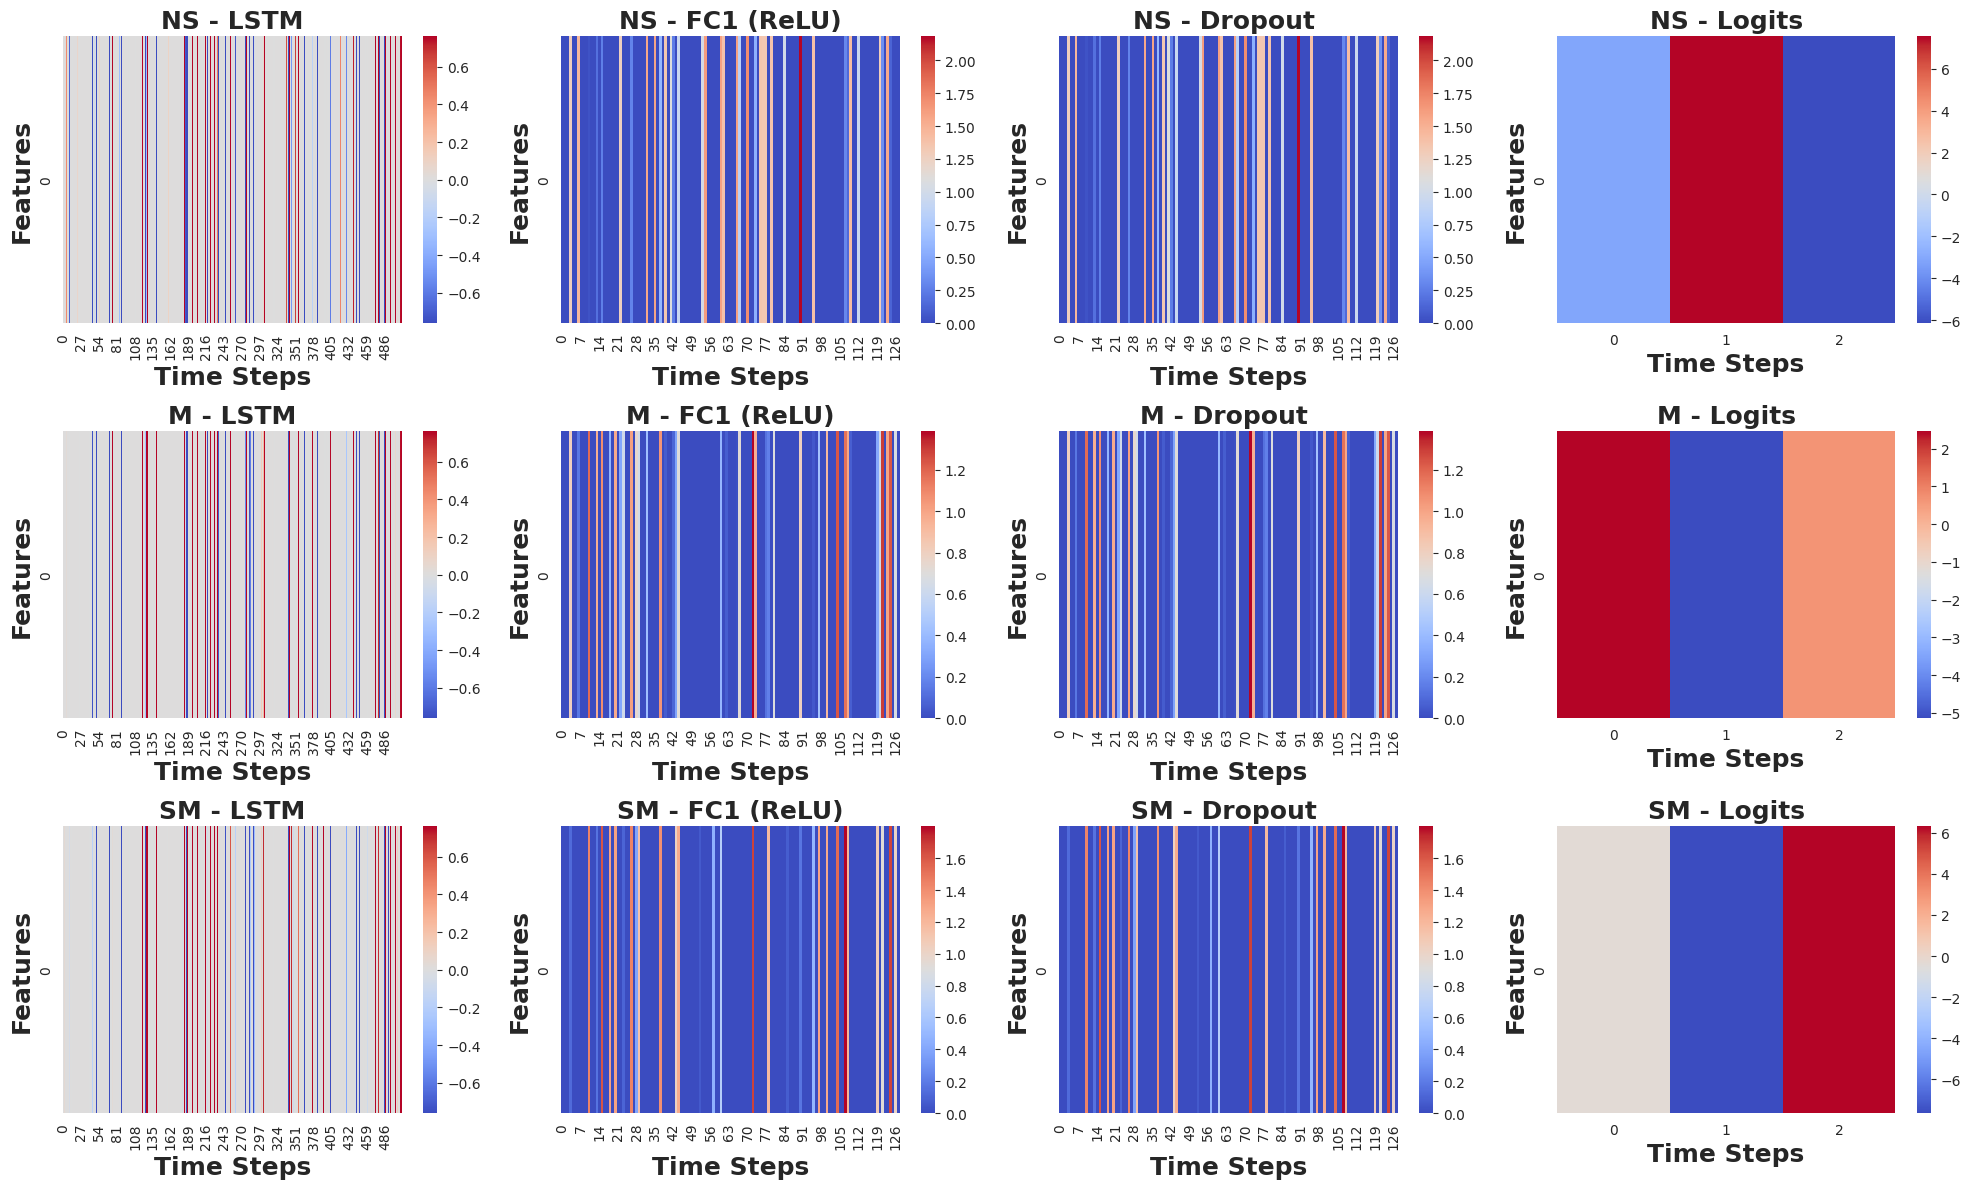

Layer-wise visualization saved as 'layer_visualization_3x4_abbr.jpeg'.


In [4]:
import torch
import torch.nn as nn
import librosa
import numpy as np
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure device compatibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ===========================
# 1. Load Trained Model
# ===========================
class CalmnessAnalysisModel(nn.Module):
    def __init__(self, input_dim=25, hidden_dim=256, num_classes=3):
        super(CalmnessAnalysisModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, audio_features):
        layer_outputs = {}

        # Input to LSTM
        audio_features = audio_features.unsqueeze(1)  # Reshape for LSTM
        lstm_out, _ = self.lstm(audio_features)
        lstm_out = lstm_out[:, -1, :]  # Take last time-step output
        layer_outputs["LSTM"] = lstm_out.detach().cpu().numpy()
        # Fully Connected Layer 1
        x = self.relu(self.fc1(lstm_out))
        layer_outputs["FC1 (ReLU)"] = x.detach().cpu().numpy()

        # Dropout Layer
        x = self.dropout(x)
        layer_outputs["Dropout "] = x.detach().cpu().numpy()

        # Fully Connected Layer 2 (Final Output)
        x = self.fc2(x)
        layer_outputs["Logits"] = x.detach().cpu().numpy()

        return x, layer_outputs

# Load the trained model
model = CalmnessAnalysisModel(input_dim=25).to(device)
model.load_state_dict(torch.load("/kaggle/input/qmsat-dataset/CAM-model-Results/best_calmness_analysis_model.pth", map_location=device))
model.eval()

# ===========================
# 2. Load Sample Audio from Each Class
# ===========================
dataset_path = "/kaggle/input/qmsat-dataset/ATS-data"
categories = ["Normal(Silence)", "Music", "SpiritualMeditation"]
sample_files = {}
for category in categories:
    category_path = os.path.join(dataset_path, category)
    for file in os.listdir(category_path):
        if file.endswith(".wav"):
            sample_files[category] = os.path.join(category_path, file)
            break  # Pick only one sample per category

# ===========================
# 3. Feature Extraction Function
# ===========================
def extract_features(file_path):
    waveform, sr = librosa.load(file_path, sr=16000)

    # MFCC Features
    mfccs = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=13).mean(axis=1)

    # Time Features (Zero-Crossing Rate & RMS)
    zcr = librosa.feature.zero_crossing_rate(waveform)[0].mean()
    rms = librosa.feature.rms(y=waveform)[0].mean()

    # Wavelet Transform Features
    coeffs = pywt.wavedec(waveform, 'db4', level=4)
    wavelet_features = []
    for c in coeffs:
        wavelet_features.append(np.mean(c) if c.size > 0 else 0)
        wavelet_features.append(np.std(c) if c.size > 0 else 0)
    wavelet_features = wavelet_features[:10]  # Keep first 10 features

    return np.concatenate([mfccs, [zcr, rms], wavelet_features])

# ===========================
# 4. Process Audio Through Model
# ===========================
layer_outputs_per_class = {}

for category, file_path in sample_files.items():
    print(f"Processing {category}: {file_path}")

    # Extract features
    features = extract_features(file_path)
    features_tensor = torch.tensor(features, dtype=torch.float32).to(device).unsqueeze(0)

    # Pass through the model and get layer outputs
    _, layer_outputs = model(features_tensor)
    layer_outputs_per_class[category] = layer_outputs

# ===========================
# 5. Visualization of Layer Outputs (3x4 Grid)
# ===========================
sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 4, figsize=(20, 12))

# Abbreviations for classes
class_abbr = {
    "Normal(Silence)": "NS",
    "Music": "M",
    "SpiritualMeditation": "SM"
}

# Iterate over layers and categories to plot the heatmaps
for row_idx, (category, layer_outputs) in enumerate(layer_outputs_per_class.items()):
    for col_idx, (layer_name, output_data) in enumerate(layer_outputs.items()):
        ax = axes[row_idx, col_idx]
        sns.heatmap(output_data, ax=ax, cmap="coolwarm", cbar=True)
        abbr_category = class_abbr[category]  # Use abbreviation for class name
        ax.set_title(f"{abbr_category} - {layer_name}", fontsize=18, fontweight='bold')
        ax.set_xlabel("Time Steps", fontsize=18, fontweight='bold')
        ax.set_ylabel("Features", fontsize=18, fontweight='bold')

# Adjust layout and save the figure as .jpeg
plt.tight_layout()
plt.savefig("layer_visualization_3x4_abbr.jpeg", dpi=300)
plt.show()

print("Layer-wise visualization saved as 'layer_visualization_3x4_abbr.jpeg'.")


/tmp/ipykernel_31/1574587211.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


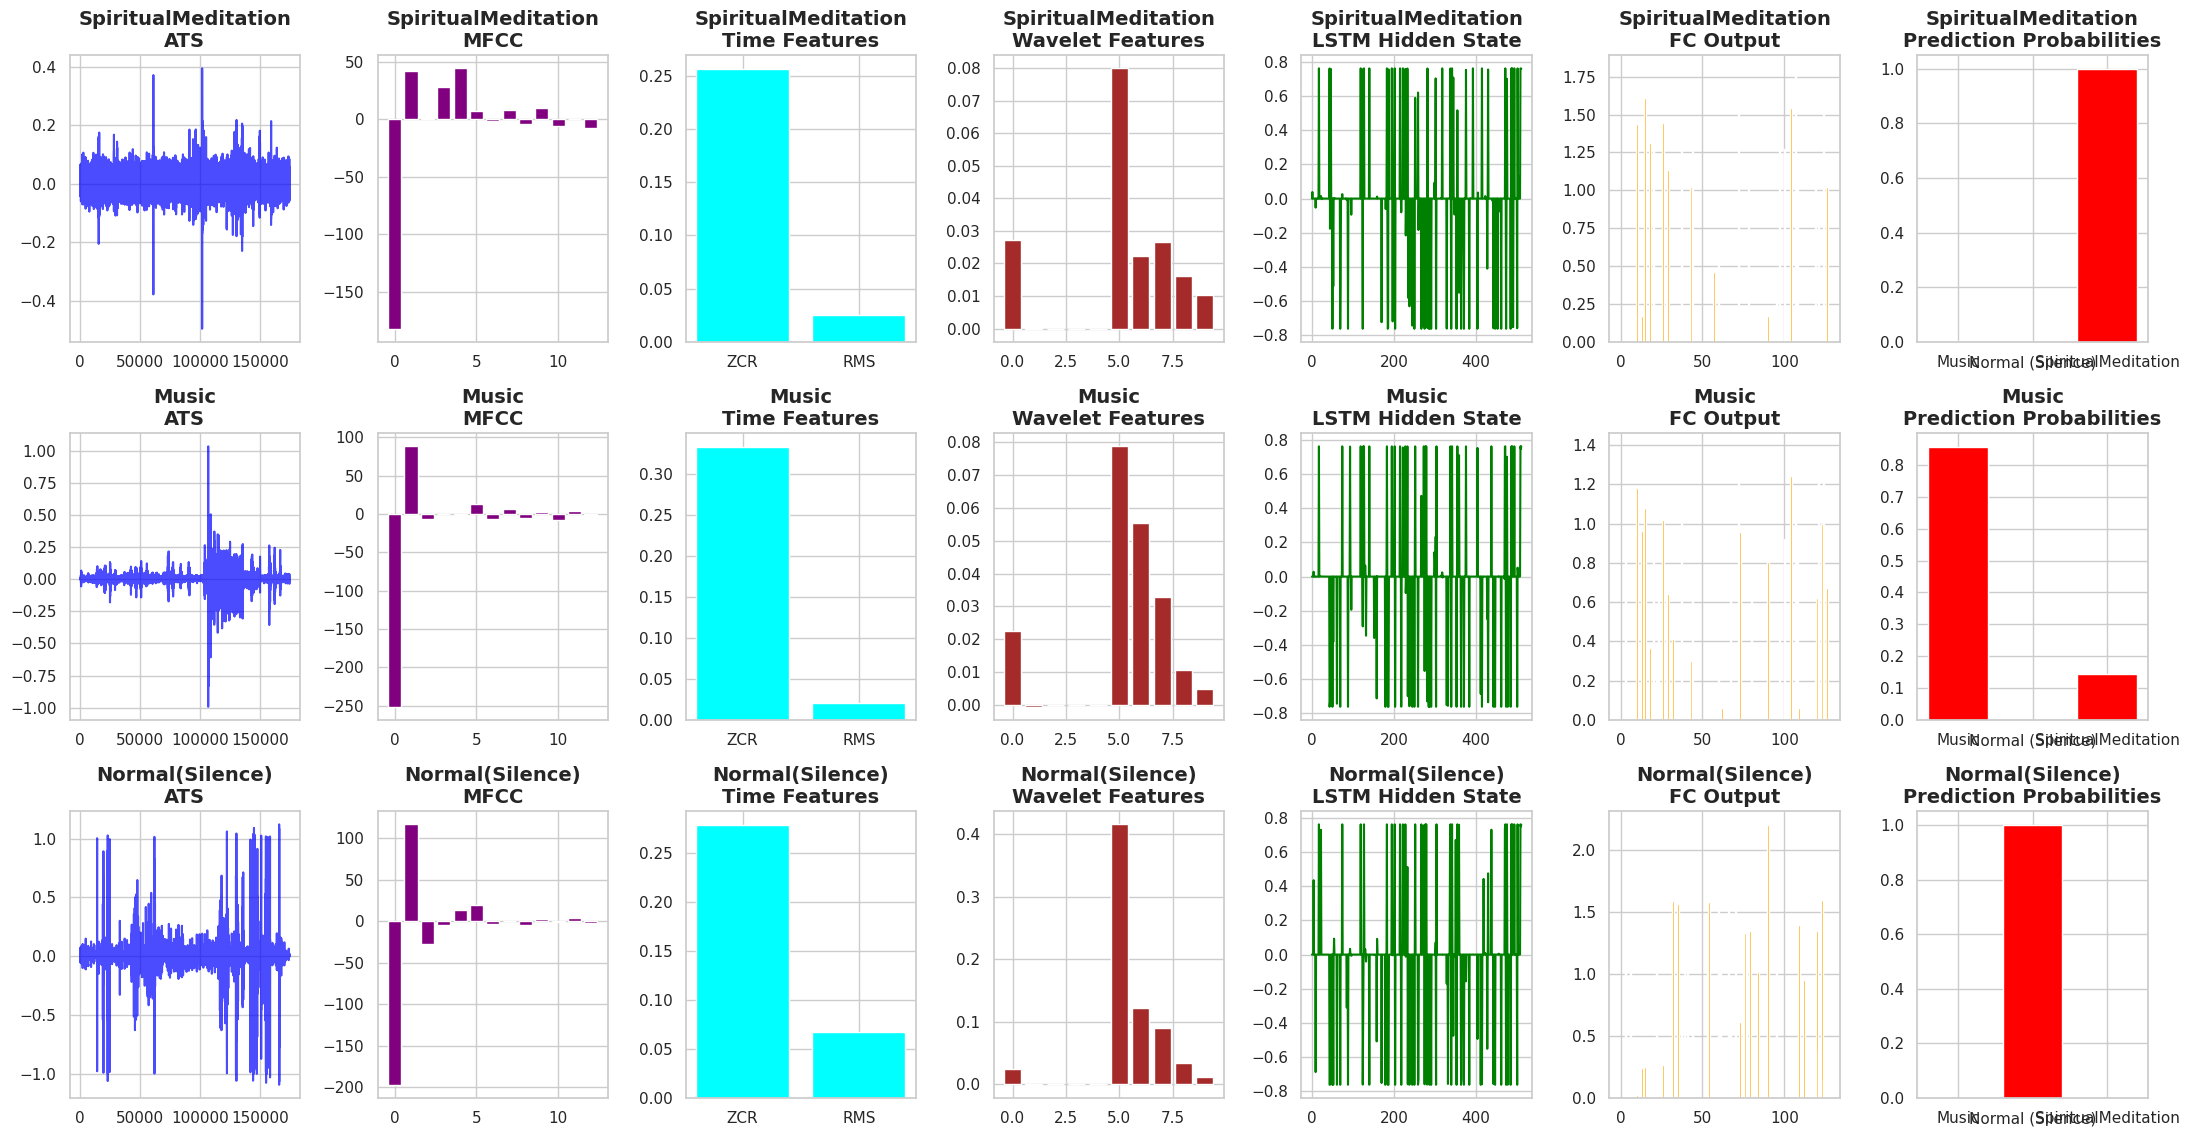

In [29]:
import torch
import torch.nn as nn
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pywt

# Set visualization style
sns.set_style("whitegrid")

# Load trained model
model_path = "/kaggle/input/qmsat-dataset/CAM-model-Results/best_calmness_analysis_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class names
class_labels = {0: "Music", 1: "Normal (Silence)", 2: "SpiritualMeditation"}

# Load model
class CalmnessAnalysisModel(nn.Module):
    def __init__(self, input_dim=25, hidden_dim=256, num_classes=3):
        super(CalmnessAnalysisModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, audio_features):
        audio_features = audio_features.unsqueeze(1)
        lstm_out, _ = self.lstm(audio_features)
        lstm_out = lstm_out[:, -1, :]
        fc1_out = self.relu(self.fc1(lstm_out))  # Extract FC1 activations
        x = self.dropout(fc1_out)
        x = self.fc2(x)
        return lstm_out, fc1_out, x  # Return FC1 activations

# Load the trained model
model = CalmnessAnalysisModel(input_dim=25).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# =====================
# 1. Load & Preprocess an Example Audio from Each Class
# =====================

def extract_features(waveform, sr=16000):
    """Extracts MFCC, time-domain, and wavelet features."""
    # MFCC Features
    mfccs = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=13).mean(axis=1)

    # Time-domain Features
    zcr = librosa.feature.zero_crossing_rate(waveform)[0].mean()
    rms = librosa.feature.rms(y=waveform)[0].mean()
    time_features = np.array([zcr, rms])

    # Wavelet Features
    coeffs = pywt.wavedec(waveform, 'db4', level=4)
    wavelet_features = [np.mean(c) if c.size > 0 else 0 for c in coeffs[:5]] + \
                       [np.std(c) if c.size > 0 else 0 for c in coeffs[:5]]

    # Combine all features
    return np.concatenate([mfccs, time_features, wavelet_features]), time_features, wavelet_features

# Load sample audio files from each class
root_dir = "/kaggle/input/qmsat-dataset/ATS-data"
sample_files = {}

for category in os.listdir(root_dir):
    category_path = os.path.join(root_dir, category)
    if os.path.isdir(category_path):
        for file in os.listdir(category_path):
            if file.endswith(".wav"):
                sample_files[category] = os.path.join(category_path, file)
                break  # Only take one sample per category

# Prepare storage for visualization
waveforms = {}
mfcc_transforms = {}
time_features_store = {}
wavelet_features_store = {}
lstm_outputs = {}
fc1_outputs = {}
final_outputs = {}

fig, axes = plt.subplots(len(sample_files), 7, figsize=(22, 12))

# =====================
# 2. Pass Through Model and Visualize Transformations
# =====================

for idx, (category, file_path) in enumerate(sample_files.items()):
    # Load audio
    waveform, sr = librosa.load(file_path, sr=16000)
    waveforms[category] = waveform

    # Extract features
    features, time_features, wavelet_features = extract_features(waveform)
    features_tensor = torch.tensor(features, dtype=torch.float32).to(device).unsqueeze(0)

    # Pass through model
    with torch.no_grad():
        lstm_out, fc1_out, final_out = model(features_tensor)

    # Store transformations
    mfcc_transforms[category] = features[:13]  # MFCC components
    time_features_store[category] = time_features  # ZCR & RMS
    wavelet_features_store[category] = wavelet_features  # Wavelet Features
    lstm_outputs[category] = lstm_out.cpu().numpy().squeeze()  # LSTM Hidden state
    fc1_outputs[category] = fc1_out.cpu().numpy().squeeze()  # Corrected FC1 output
    final_outputs[category] = final_out.cpu().numpy().squeeze()  # Final output (logits)

    # =====================
    # 3. Plot Layer-by-Layer Transformations
    # =====================

    # 1. Original Waveform
    axes[idx, 0].plot(waveform, color="blue", alpha=0.7)
    axes[idx, 0].set_title(f"{category}\nATS", fontsize=14, fontweight='bold')

    # 2. MFCC Features
    axes[idx, 1].bar(range(13), mfcc_transforms[category], color="purple")
    axes[idx, 1].set_title(f"{category}\nMFCC", fontsize=14, fontweight='bold')

    # 3. Time-domain Features (ZCR & RMS)
    axes[idx, 2].bar(["ZCR", "RMS"], time_features_store[category], color="cyan")
    axes[idx, 2].set_title(f"{category}\nTime Features", fontsize=14, fontweight='bold')

    # 4. Wavelet Features
    axes[idx, 3].bar(range(len(wavelet_features_store[category])), wavelet_features_store[category], color="brown")
    axes[idx, 3].set_title(f"{category}\nWavelet Features", fontsize=14, fontweight='bold')

    # 5. LSTM Hidden State
    axes[idx, 4].plot(lstm_outputs[category], color="green")
    axes[idx, 4].set_title(f"{category}\nLSTM Hidden State", fontsize=14, fontweight='bold')

    # 6. Fully Connected Layer Output
    if len(fc1_outputs[category]) == 128:
        axes[idx, 5].bar(range(128), fc1_outputs[category], color="orange")
        axes[idx, 5].set_title(f"{category}\nFC Output", fontsize=14, fontweight='bold')
    else:
        print(f"Warning: Unexpected shape {fc1_outputs[category].shape} in FC1 output.")

    # 7. Softmax Prediction (Final Probabilities)
    softmax_probs = torch.softmax(torch.tensor(final_outputs[category]), dim=0).numpy()
    axes[idx, 6].bar(list(class_labels.values()), softmax_probs, color="red")
    axes[idx, 6].set_title(f"{category}\nPrediction Probabilities", fontsize=14, fontweight='bold')

# Adjust layout and fix title overlaps
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Removed the main title (suptitle)
plt.savefig("model_visualization.jpeg", dpi=300)
plt.show()


**SMSAT**

In [47]:
import os
import random
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import matplotlib as mpl
from torchinfo import summary
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

# Set global font to Times New Roman and style.
mpl.rcParams["font.family"] = "Times New Roman"
sns.set(font="Times New Roman", style="whitegrid", palette="dark")

# ----------------------------
# 1. Model Definition
# ----------------------------
class Encoder(nn.Module):
    def __init__(self, projection_dim=128):
        super(Encoder, self).__init__()
        self.mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=64)
        self.db_transform = torchaudio.transforms.AmplitudeToDB()
        resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        self.projection = nn.Linear(512, projection_dim)
    
    def forward(self, x):
        if x.dim() == 3:
            x = x.squeeze(1)
        mel = self.mel_spec(x)
        mel_db = self.db_transform(mel).unsqueeze(1)
        features = self.encoder(mel_db).squeeze(-1).squeeze(-1)
        projection = self.projection(features)
        return projection
    
    def encode(self, x):
        return self.forward(x)

# ----------------------------
# 2. Dataset Definition and Collate Function
# ----------------------------
class Dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, sample_rate=16000):
        self.sample_rate = sample_rate
        self.file_paths = []
        self.labels = []
        for sub_dir in ["SpiritualMeditation", "Music", "Normal(Silence)"]:
            folder = Path(root_dir) / sub_dir
            wav_files = glob.glob(str(folder / '*.wav'))
            self.file_paths.extend(wav_files)
            self.labels.extend([sub_dir] * len(wav_files))
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        waveform, sr = torchaudio.load(file_path)
        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)
        # Use first channel if stereo.
        if waveform.dim() == 2:
            waveform = waveform[0].unsqueeze(0)
        label = self.labels[idx]
        return waveform, label

def collate_fn(batch):
    max_len = max(item[0].shape[1] for item in batch)
    padded, labels = [], []
    for waveform, label in batch:
        pad_amt = max_len - waveform.shape[1]
        if pad_amt > 0:
            waveform = F.pad(waveform, (0, pad_amt))
        padded.append(waveform)
        labels.append(label)
    return torch.stack(padded, dim=0), labels

# ----------------------------
# 3. Embedding Computation and t-SNE Visualization
# ----------------------------
def compute_embeddings(model, dataloader, device):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for waveform, label in dataloader:
            waveform = waveform.to(device)
            emb = model.encode(waveform)
            embeddings.append(emb.cpu().numpy())
            labels.extend(label)
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings, labels

def plot_tsne_scatter(embeddings, labels):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced = tsne.fit_transform(embeddings)
    df = pd.DataFrame(reduced, columns=["Dim1", "Dim2"])
    df["Label"] = labels
    plt.figure(figsize=(8,6))
    sns.scatterplot(x="Dim1", y="Dim2", hue="Label", data=df, s=60, alpha=0.8)
    plt.title("t-SNE Embedding of Audio Samples", fontsize=12)
    plt.tight_layout()
    plt.savefig("tsne_scatter.png", dpi=300, bbox_inches="tight")
    plt.show()
    return df, reduced

def compute_centroids(reduced, labels):
    df = pd.DataFrame(reduced, columns=["Dim1", "Dim2"])
    df["Label"] = labels
    centroids = df.groupby("Label").mean().reset_index()
    return centroids

import matplotlib.lines as mlines

def plot_centroid_scatter(df, centroids):
    plt.figure(figsize=(8,6))
    
    # Create a color palette based on unique labels
    unique_labels = df['Label'].unique()
    palette = sns.color_palette("Set1", len(unique_labels))  # Use a predefined color palette

    # Define a dictionary for the abbreviated class names
    label_abbreviations = {
        "SpiritualMeditation": "SM",
        "Music": "M",
        "Normal(Silence)": "NS"
    }

    # Plot the scatter plot with class labels as hues
    sns.scatterplot(x="Dim1", y="Dim2", hue="Label", data=df, s=60, alpha=0.8, palette=palette)

    # Plot centroids with distinct markers (X) and color them
    for i, (_, row) in enumerate(centroids.iterrows()):
        label = row['Label']
        centroid_color = palette[unique_labels.tolist().index(label)]  # Get corresponding color for label
        plt.scatter(row["Dim1"], row["Dim2"], s=200, marker="X", color=centroid_color)
        
        # Use the custom abbreviation for the label
        abbreviated_label = label_abbreviations.get(label, label)  # Default to full label if not in dict
        plt.text(row["Dim1"] + 0.2, row["Dim2"] + 0.2, abbreviated_label, fontsize=12, fontweight="bold", 
                 color=centroid_color, ha='left')

        # Draw a circle around the centroid for better distinction
        circle = mlines.Line2D([row["Dim1"]], [row["Dim2"]], marker='o', color='none', markerfacecolor=centroid_color,
                               markersize=10, markeredgewidth=2)
        plt.gca().add_line(circle)

    # Add a legend to indicate what each color corresponds to (class name)
    for i, label in enumerate(unique_labels):
        plt.scatter([], [], color=palette[i], label=label)  # Create dummy scatter points for the legend
    plt.legend(title="Class Labels", loc="best", fontsize=12, title_fontsize=14)

    # Add main plot title
    plt.title("t-SNE Embedding with Class Centroids", fontsize=14, fontweight='bold')

    # Adjust layout for clarity and save plot
    plt.tight_layout()
    plt.savefig("centroid_scatter.png", dpi=300, bbox_inches="tight")
    plt.show()


def plot_statistics(embeddings, labels):
    # Dimensionality reduction using t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced = tsne.fit_transform(embeddings)
    df = pd.DataFrame(reduced, columns=["Dim1", "Dim2"])
    df["Label"] = labels
    centroids = df.groupby("Label").mean().reset_index()
    
    # Compute inter-class and intra-class distances
    inter_distances, intra_distances = compute_inter_intra_distances(reduced, labels)
    
    # Set up the figure and axes for plotting
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))  # 1x3 subplot grid
    
    # Class abbreviations and colors for legend
    class_abbr = {"SpiritualMeditation": "SM", "Music": "M", "Normal(Silence)": "NS"}
    colors = {"SM": 'red', "M": 'blue', "NS": 'green'}

    # t-SNE scatter plot with centroids and color-coded circles
    sns.scatterplot(ax=axs[0], x="Dim1", y="Dim2", hue="Label", data=df, s=60, alpha=0.8)
    for _, row in centroids.iterrows():
        label = row["Label"]
        abbr = class_abbr[label]
        axs[0].scatter(row["Dim1"], row["Dim2"], s=200, marker="X", color=colors[abbr])
        axs[0].text(row["Dim1"]+0.2, row["Dim2"]+0.2, abbr, fontsize=13, fontweight="bold", color=colors[abbr], ha='left')
    axs[0].set_title("t-SNE Embedding with Centroids", fontsize=13, fontweight='bold')
    axs[0].set_xlabel("Dim1", fontsize=13, fontweight='bold')
    axs[0].set_ylabel("Dim2", fontsize=13, fontweight='bold')
    
    # Inter-class distances plot
    plot_inter_distances(inter_distances, axs[1])
    axs[1].set_title("Inter-Class Distances", fontsize=13, fontweight='bold')
    axs[1].set_xlabel("Classes", fontsize=13, fontweight='bold')
    axs[1].set_ylabel("Euclidean Distance", fontsize=13, fontweight='bold')

    # Intra-class distances plot
    plot_intra_distances(intra_distances, axs[2])
    axs[2].set_title("Intra-Class Distances", fontsize=13, fontweight='bold')
    axs[2].set_xlabel("Classes", fontsize=13, fontweight='bold')
    axs[2].set_ylabel("Distance", fontsize=13, fontweight='bold')

    # Adding color-coded circle for each class in the main plot title (legend)
    axs[0].legend(title="Classes", labels=["SM", "M", "NS"], loc="upper left", fontsize=12)
    axs[0].scatter([], [], color='red', label="SM", s=200, marker="X")
    axs[0].scatter([], [], color='blue', label="M", s=200, marker="X")
    axs[0].scatter([], [], color='green', label="NS", s=200, marker="X")

    plt.tight_layout()
    plt.savefig("statistics_plots.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    # Print class statistics
    print_class_statistics(reduced, labels)


def visualize_activations(activations, sample_label, input_waveform):
    plots = []
    input_data = input_waveform[0].squeeze().numpy()
    plots.append(("ATS Signal", input_data))
    for layer_name, output in activations.items():
        plots.append((layer_name, output[0]))
    
    n_plots = len(plots)
    n_cols = 11
    n_rows = 3
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2.5))
    axs = axs.flatten()

    # Assign distinct colors for each class
    colors = ['red', 'blue', 'green']
    
    for i, (title, data) in enumerate(plots):
        ax = axs[i]
        if title == "ATS Signal":
            ax.plot(data, color=colors[i % len(colors)], linewidth=1)
        else:
            if data.ndim == 3:
                act_mean = data.mean(axis=0)  # axis=0 for batch mean
                im = ax.imshow(act_mean, aspect='auto', cmap='viridis')
            elif data.ndim == 2:
                ax.bar(np.arange(data.shape[0]), data, color=colors[i % len(colors)])
            else:
                ax.plot(data, color=colors[i % len(colors)], linewidth=1)
        ax.set_title(f'({chr(97 + i)}) {title}', fontsize=13, fontweight='bold')
        ax.set_xlabel("Time Steps", fontsize=13, fontweight='bold')
        ax.set_ylabel("Amplitude", fontsize=13, fontweight='bold')

    # Hide any unused subplots
    for j in range(i+1, len(axs)):
        axs[j].axis("off")
    
    # Set the main title
    #fig.suptitle(f"Activations for {sample_label}", fontsize=16, fontweight='bold')

    # Adjust layout and save the plot
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(f"activations_{sample_label}.png", dpi=300, bbox_inches="tight")
    plt.show()




Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/tmp/ipykernel_31/3873764254.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(to

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Mult-Adds
Encoder                                       [1, 1, 16000]             [1, 128]                  --                        --
├─MelSpectrogram: 1-1                         [1, 16000]                [1, 64, 81]               --                        --
│    └─Spectrogram: 2-1                       [1, 16000]                [1, 201, 81]              --                        --
│    └─MelScale: 2-2                          [1, 201, 81]              [1, 64, 81]               --                        --
├─AmplitudeToDB: 1-2                          [1, 64, 81]               [1, 64, 81]               --                        --
├─Sequential: 1-3                             [1, 1, 64, 81]            [1, 512, 1, 1]            --                        --
│    └─Conv2d: 2-3                            [1, 1, 64, 81]            [1, 64, 32, 41]           3,136 

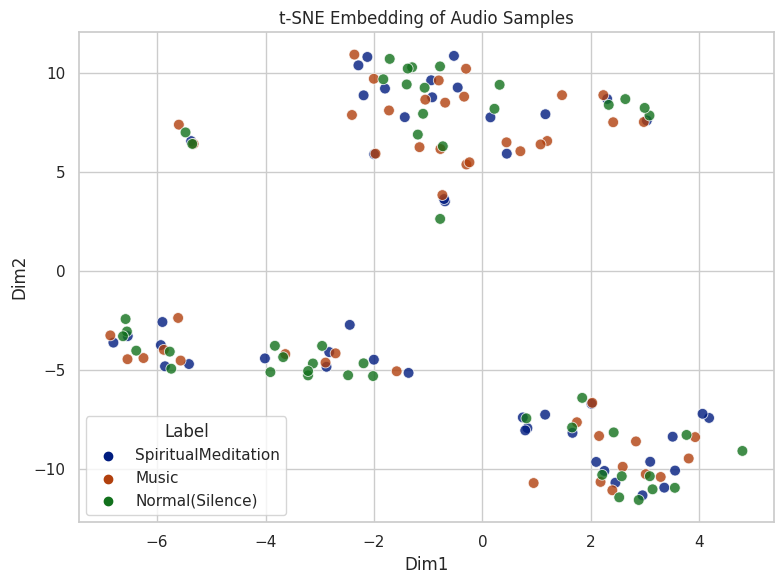

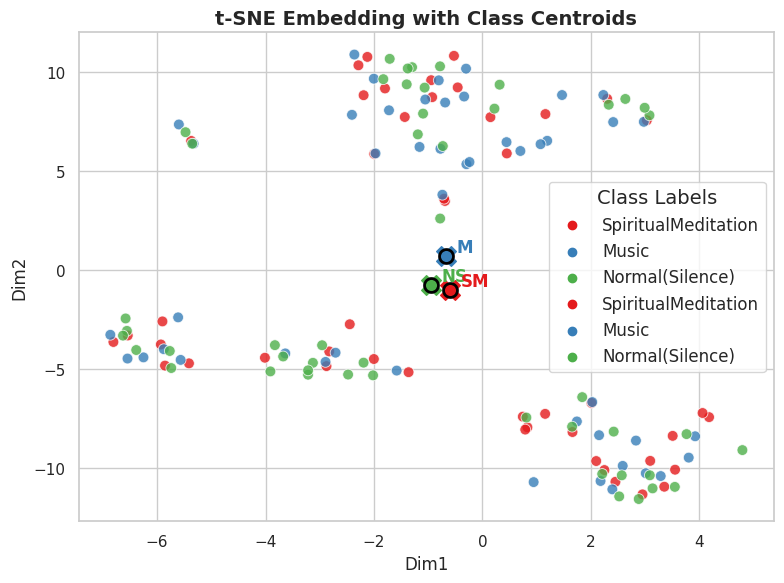

Inter-Class Distances: {'SM vs Music': 1.740091, 'SM vs Normal(Silence)': 0.4514107}


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


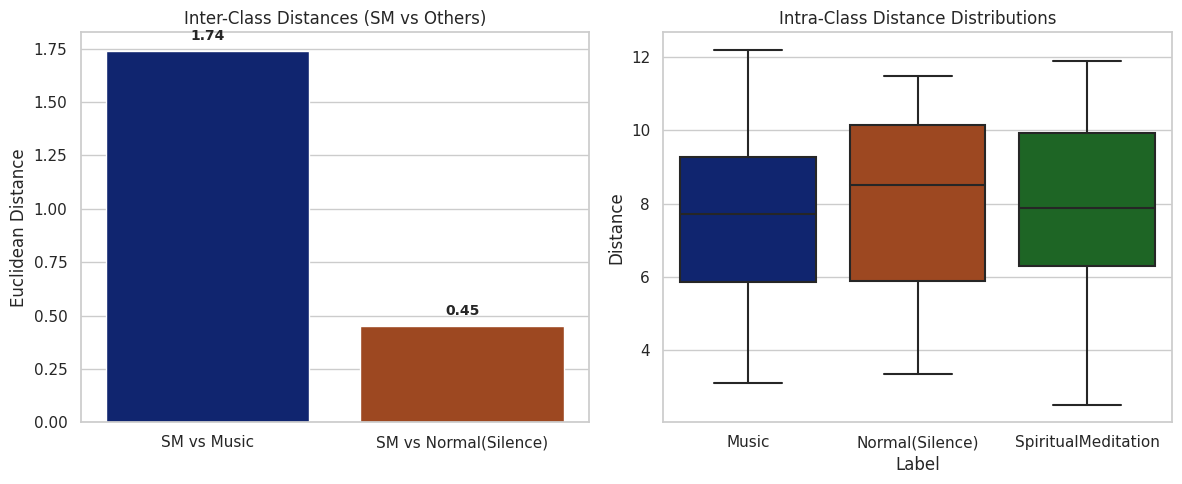

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


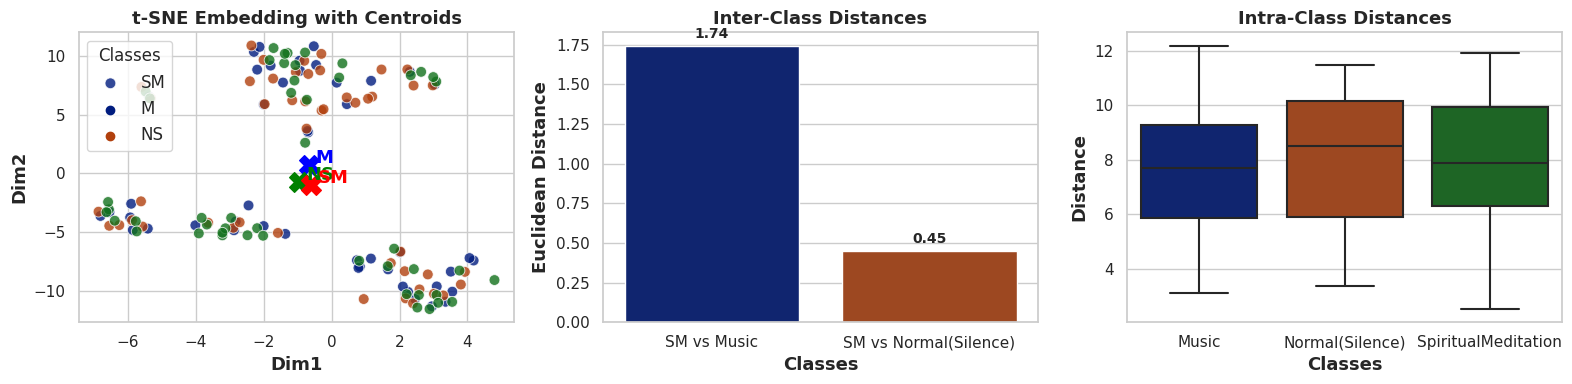


Detailed Class Statistics:
              Label  Count  Mean Distance  Median Distance  Std Distance  Min Distance  Max Distance
SpiritualMeditation     46       7.828979         7.877342      2.390274      2.518498     11.906076
              Music     47       7.856313         7.709873      2.194345      3.099498     12.195729
    Normal(Silence)     48       7.992275         8.517311      2.512323      3.350785     11.496915


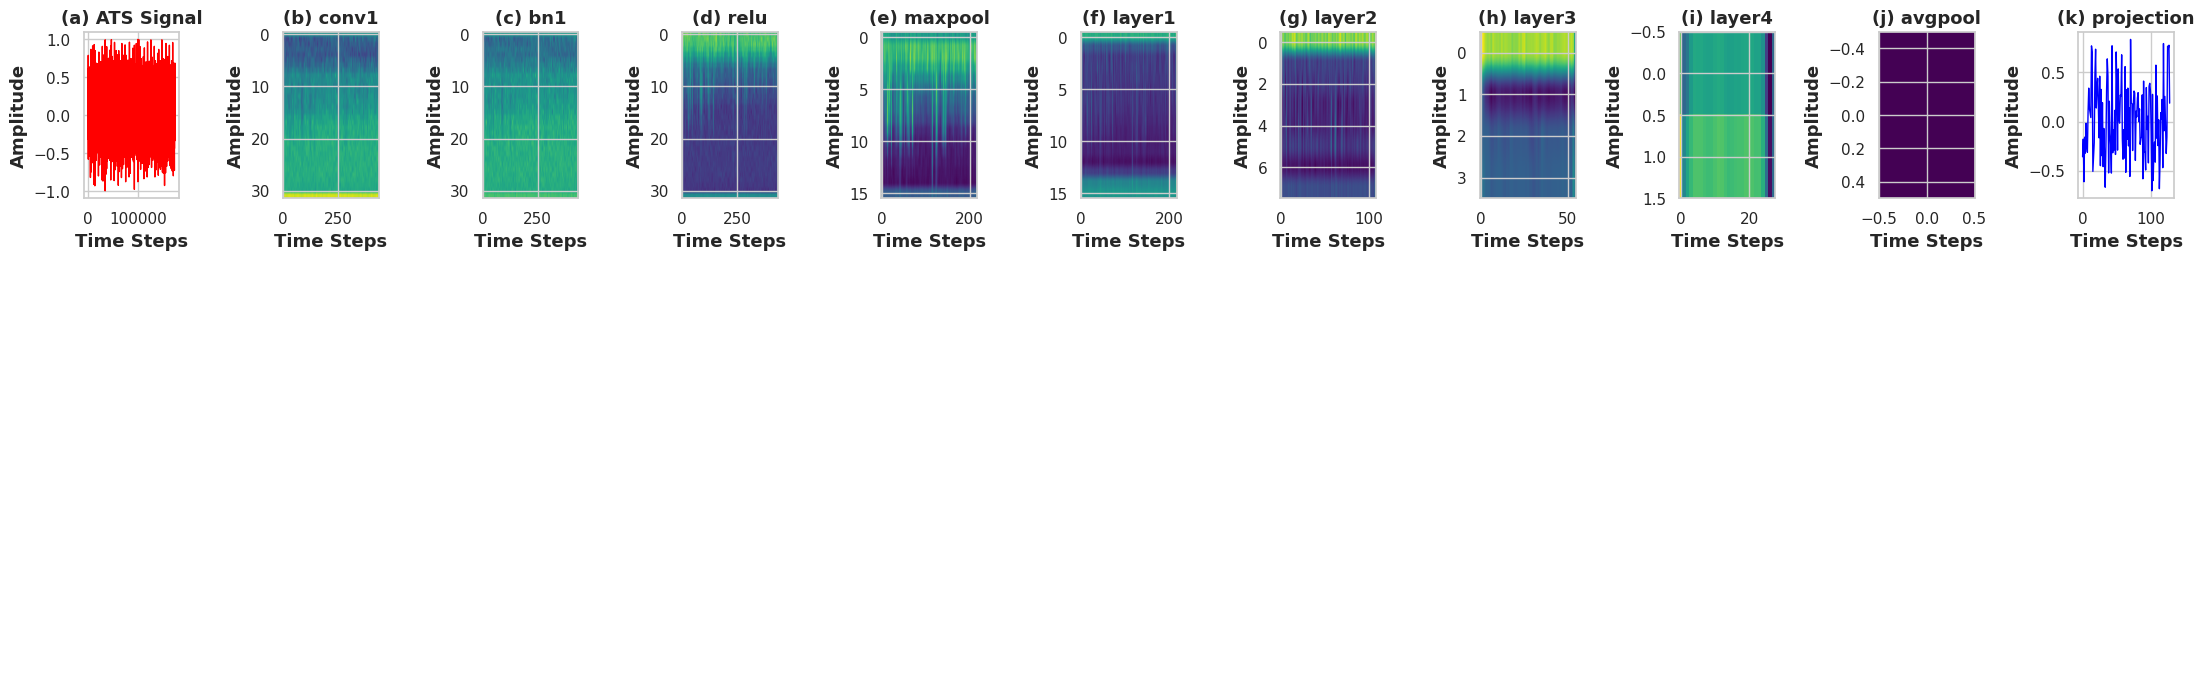

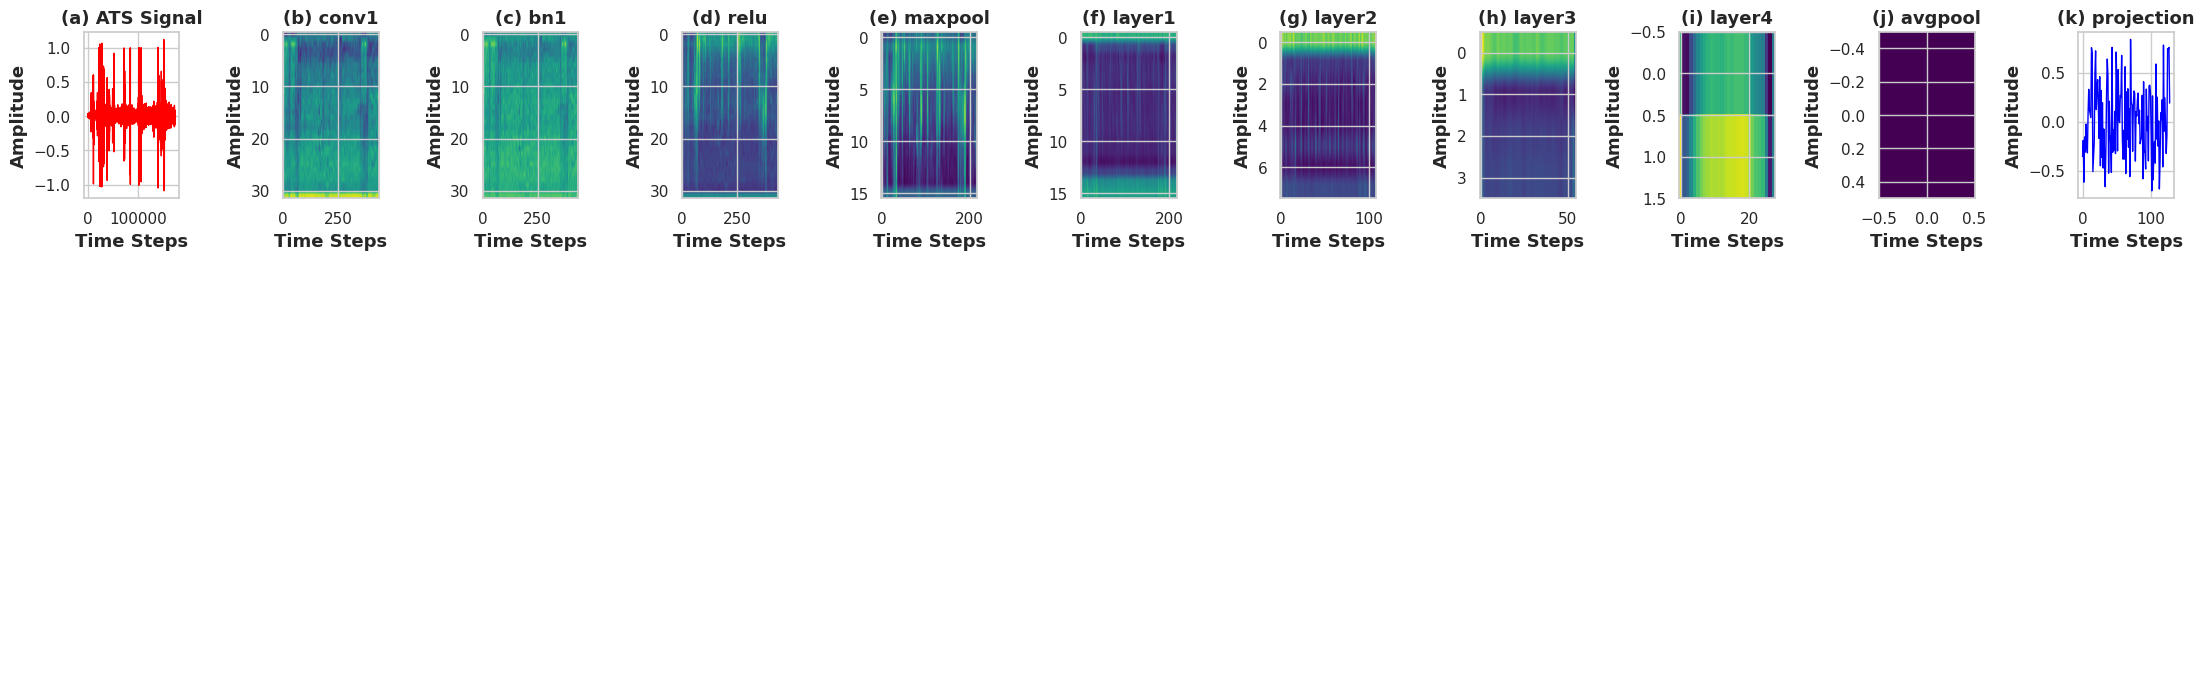

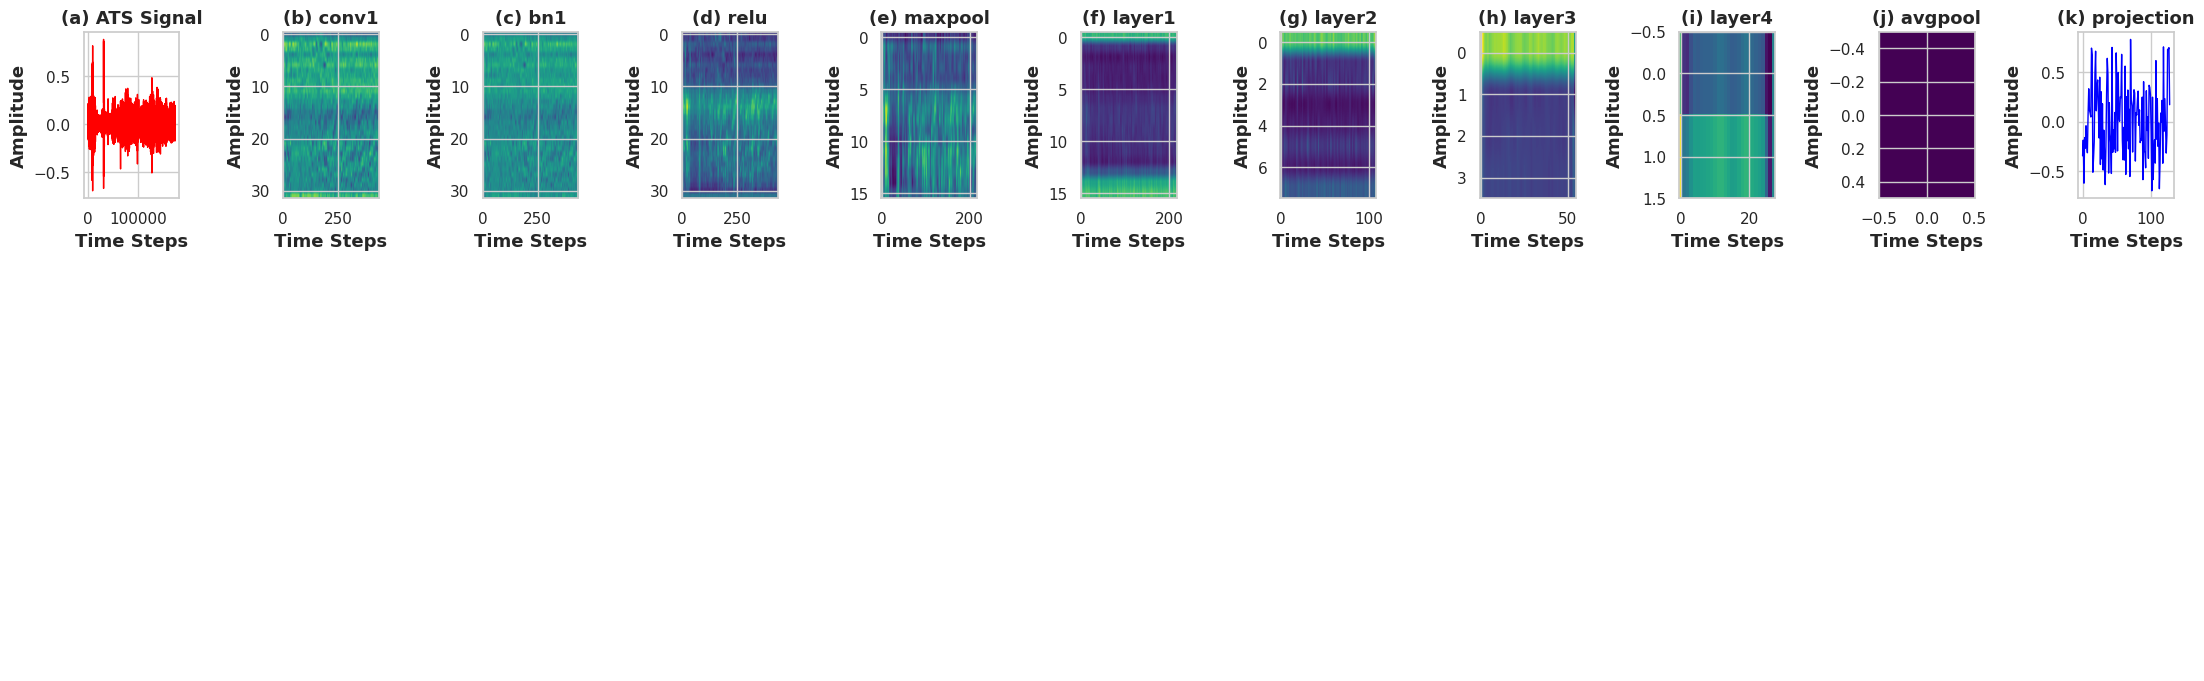

In [48]:
# ----------------------------
# 5. Main Execution
# ----------------------------
def main():
    root_dir = '/kaggle/input/qmsat-dataset/ATS-data'
    sample_rate = 16000
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load trained model.
    model = Encoder(projection_dim=128).to(device)
    model_save_path = "/kaggle/input/qmsat-dataset/SMSAT-Encoder-Results/trained_resnet_audio_encoder.pth"
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    model.eval()
    print(summary(model, input_size=(1, 1, 16000), col_names=["input_size", "output_size", "num_params", "mult_adds"], depth=2))
    
    # Create dataset and DataLoader for embedding analysis.
    dataset = Dataset(root_dir, sample_rate=sample_rate)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
    embeddings, labels = compute_embeddings(model, dataloader, device)
    df_tsne, reduced = plot_tsne_scatter(embeddings, labels)
    centroids = compute_centroids(reduced, labels)
    plot_centroid_scatter(df_tsne, centroids)
    inter_distances, intra_distances = compute_inter_intra_distances(reduced, labels)
    print("Inter-Class Distances:", inter_distances)
    fig_stats, axs = plt.subplots(1, 2, figsize=(12,5))
    plot_inter_distances(inter_distances, axs[0])
    plot_intra_distances(intra_distances, axs[1])
    plt.tight_layout()
    plt.savefig("distance_statistics.png", dpi=300, bbox_inches="tight")
    plt.show()
    plot_statistics(embeddings, labels)
    
    # Activation visualization for each class.
    for cls in ["SpiritualMeditation", "Music", "Normal(Silence)"]:
        waveform, _ = dataset[random.choice([i for i, lab in enumerate(dataset.labels) if lab == cls])]
        if waveform.dim() == 2:
            waveform = waveform.unsqueeze(0)
        activations.clear()
        hooks = register_hooks(model)
        with torch.no_grad():
            _ = model(waveform.to(device))
        for h in hooks:
            h.remove()
        visualize_activations(activations, cls, waveform)

if __name__ == "__main__":
    main()